In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
np.random.seed(1)

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,10)
legend_fontsize = 16

# Байесовский вывод в линейной регрессии

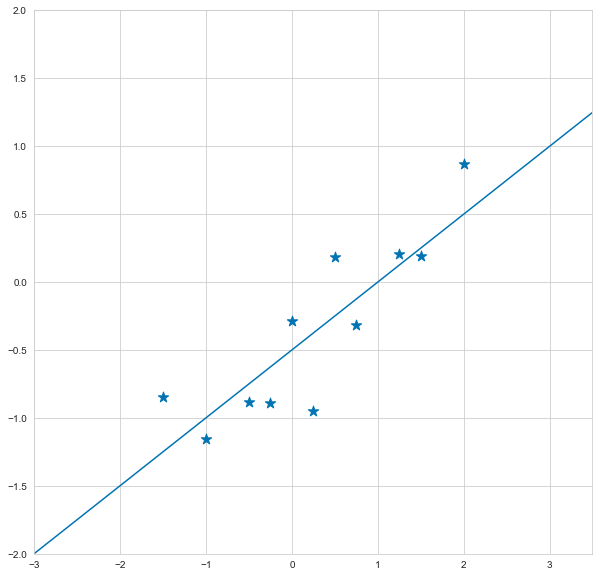

In [2]:
## Исходная функция
orig = lambda x : .5*x - .5

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.plot(xs, orig(xs))
ax.scatter(xd, data, marker='*', s=120)
plt.show()

In [3]:
from scipy.stats import multivariate_normal

# create data
N = 250
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter([-.5], [.5], marker='*', s=120)
    plt.show()

(250, 250)


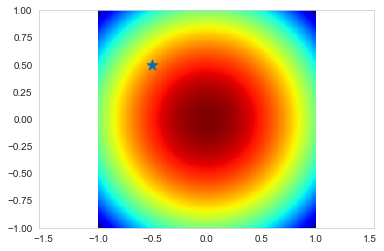

In [4]:
cur_mu, cur_sigma = np.array([0, 0]), 200*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

In [5]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((-3, 3))
    plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()

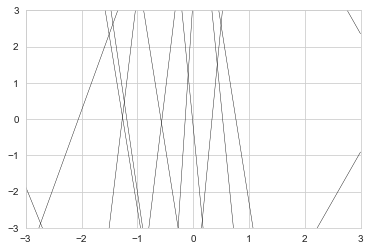

In [6]:
myplot_sample_lines(cur_mu, cur_sigma, 20)

-0.5 -0.8820429380658639


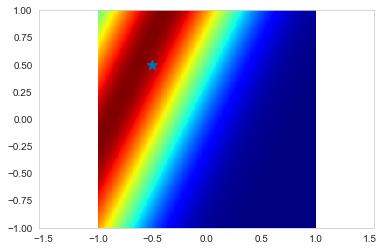

In [7]:
def get_likelihood(px, py):
    return lambda x : np.exp(-2*(x[0] + x[1]*px - py) ** 2) / (.25 * np.sqrt(2.*np.pi))

print(xd[2], data[2])
px, py = xd[2], data[2]
cur_likelihood = get_likelihood(px, py)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

myplot_heatmap(Z)

In [8]:
def bayesian_update(mu, sigma, x, y):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (.25 ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (.25 ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

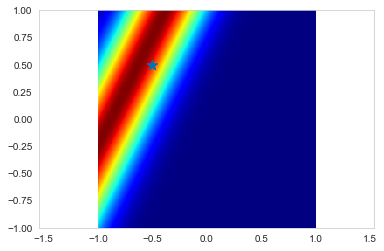

In [9]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

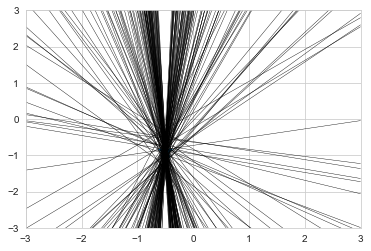

In [11]:
# Посэмплируем и порисуем прямые
myplot_sample_lines(cur_mu, cur_sigma, 200, points=[[px], [py]])

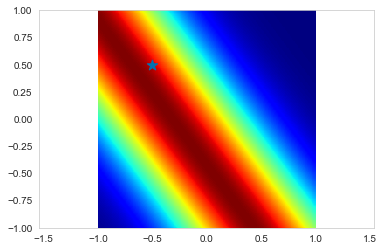

In [12]:
px2, py2 = xd[7], data[7]
cur_likelihood = get_likelihood(px2, py2)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
myplot_heatmap(Z)

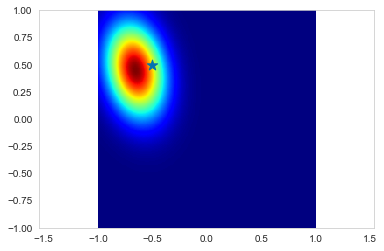

In [13]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px2, py2)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

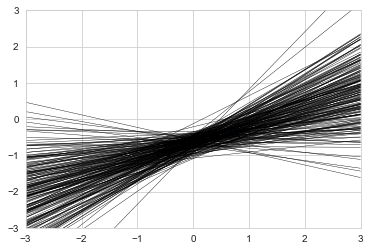

In [14]:
myplot_sample_lines(cur_mu, cur_sigma, n=200, points=[[px, px2], [py, py2]])

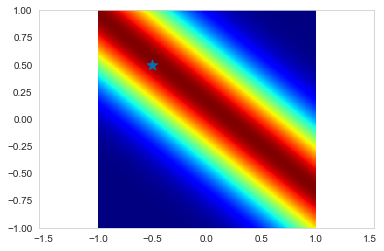

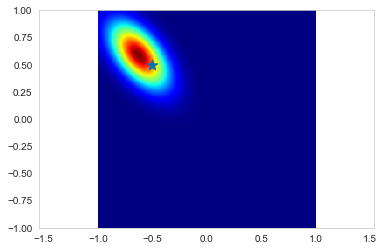

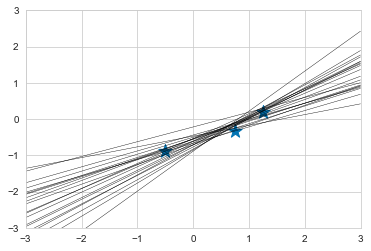

In [15]:
px3, py3 = xd[8], data[8]
cur_likelihood = get_likelihood(px3, py3)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
myplot_heatmap(Z)
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px3, py3)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)
myplot_sample_lines(cur_mu, cur_sigma, n=20, points=[[px, px2, px3], [py, py2, py3]])

## Усреднение

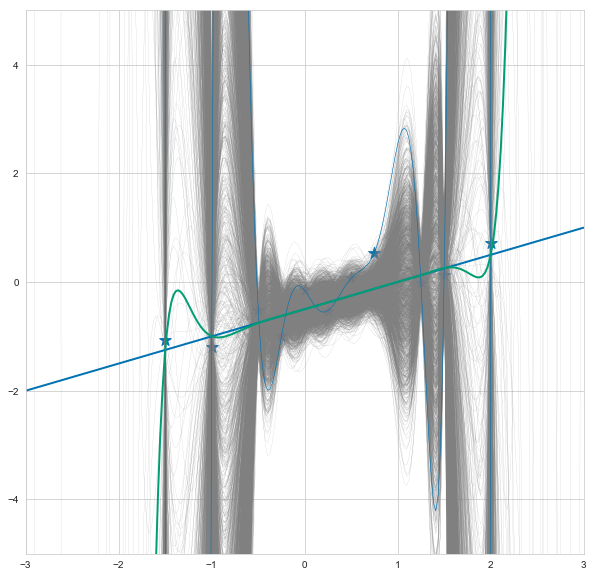

In [22]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-5, 5))

## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

res = []
for _ in range(2000):
    cur_data = orig(xd) + np.random.normal(0, .25, num_points)
    cur_model = linear_model.Ridge(alpha=0.00, fit_intercept=True).fit( xd_d, cur_data )
    res.append(cur_model.predict( xs_d ))
    ax.plot(xs, res[-1], linewidth=.1, color="0.5")

ax.plot(xs, res[-1], linewidth=.6)
ax.plot(xs, orig(xs), linewidth=2, label="Original function", color=palette[0])
ax.scatter(xd, cur_data, marker='*', s=150, color=palette[0])

ax.plot(xs, np.mean( res, axis=0 ), linewidth=2, label="Averaged predictions", color=palette[2])
plt.show()